# Modelo de Bateria

In [12]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import polars as ps
from battery_utils import get_inter_soc_mid, get_inter_soc_inf, get_inter_soc_sup

## Execução

### Componentes e OVC em função do SoC

In [29]:
def r0(z):
    #base = 0.000692967159276634
    base = 700*10**(-6)
    return base*0.9+z*base*0.1

def r1(z):
    #base = 0.001069194611620272
    base = 1.588e-04 #1*10**(-3)
    return base*0.9+z*base*0.1

def c1(z):
    #base = 25388.268613572694
    base = 1.585e+05 #30_000
    return base*0.9+z*base*0.1

def r2(z):
    #base = 0
    base = 5.246e-05 #80*10**(-6)
    return base*0.9+z*base*0.1

def c2(z):
    #base = 0
    base = 6.838e+06 #5_000
    return base*0.9+z*base*0.1

cs_mid = get_inter_soc_mid()
def OCV(z):
    if z<0.05:
        return 0
    if z>1:
        return 3.5
    return cs_mid(z)

### Update dos valores

In [30]:
def update_z(z, Q, n, i, d_t):
    '''
    z: SoC
    Q: capacidade total (As)
    n: eficiência coulombiana/carga
    i: corrente (A)
    d_t: variação no tempo (s)
    '''
    d_h = d_t/3600
    z -= n*i*(d_h/Q)
    return max(z,0)

In [31]:
def update_v(z, i_r0, i_r1, i_r2=0):
    return OCV(z) - i_r0*r0(z) - i_r1*r1(z) - i_r2*r2(z)

In [32]:
#d_t em segundos nessa equação
def update_i_r1(z, i_r0, i_r1, d_t):
    e = np.exp(-d_t/(c1(z)*r1(z)))
    return i_r1*e+i_r0*(1-e)

def update_i_r2(z, i_r0, i_r2, d_t):
    e = np.exp(-d_t/(c1(z)*r2(z)))
    return i_r2*e+i_r0*(1-e)

### Loop de execução

In [33]:
z = 1 # SoC
Q = 100 # capacidade total (Ah) (100Ah)
d_t = 0.01 # variação no tempo (s)
n = 1 # eficiência coulombiana/carga
i_r1 = 0 # corrente (A)
i_r2 = 0 # corrente (A)
i0 = 100 # corrente (A)

V = []
I1 = []
Z = []
pausa = int(3600/d_t)
descarga = int(pausa*0.1)
I0 = ([0.0]*pausa+[i0]*descarga)*3 # corrente (A)

for i_r0 in I0:
    if z <= 0:
        I0 = I0[:len(V)]
        break
    # Update dos valores
    v = update_v(z, i_r0, i_r1, i_r2)

    z = update_z(z, Q, n, i_r0, d_t)

    i_r1 = update_i_r1(z, i_r0, i_r1, d_t)
    i_r2 = update_i_r2(z, i_r0, i_r2, d_t)
    # Armazenamento dos valores
    V.append(v)
    Z.append(z)
    I1.append(i_r1)

t = np.arange(len(V))
df = ps.DataFrame(data={'t':t,'V': V, 'I0': I0, 'Z': Z})
df['dV'] = df['V'].diff()
df['dI'] = df['I0'].diff()

### Gráficos

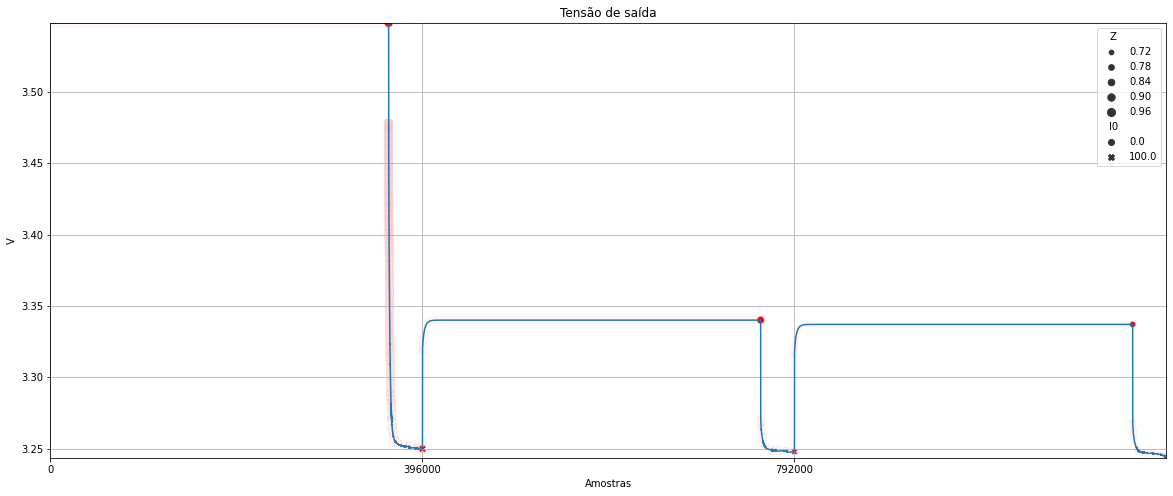

In [34]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=df.to_pandas(), x='t', y='V')
sns.scatterplot(data=df.to_pandas(), x='t', y='V', style='I0', size='Z', color='red')
plt.ylabel('V')
plt.xlabel('Amostras')
plt.title('Tensão de saída')
plt.ylim([min(V), max(V)])
plt.xlim([0, len(V)])
plt.xticks(np.arange(0, len(V), pausa+descarga))
plt.grid()
plt.show()
plt.close()

## Extração de Parametros

### OVC

In [8]:
# Filtra somente os pontos relevantes para a retirada do OCV
df_ovc = df.filter((ps.col('dI') > 0).shift(-1))[['t', 'V']]

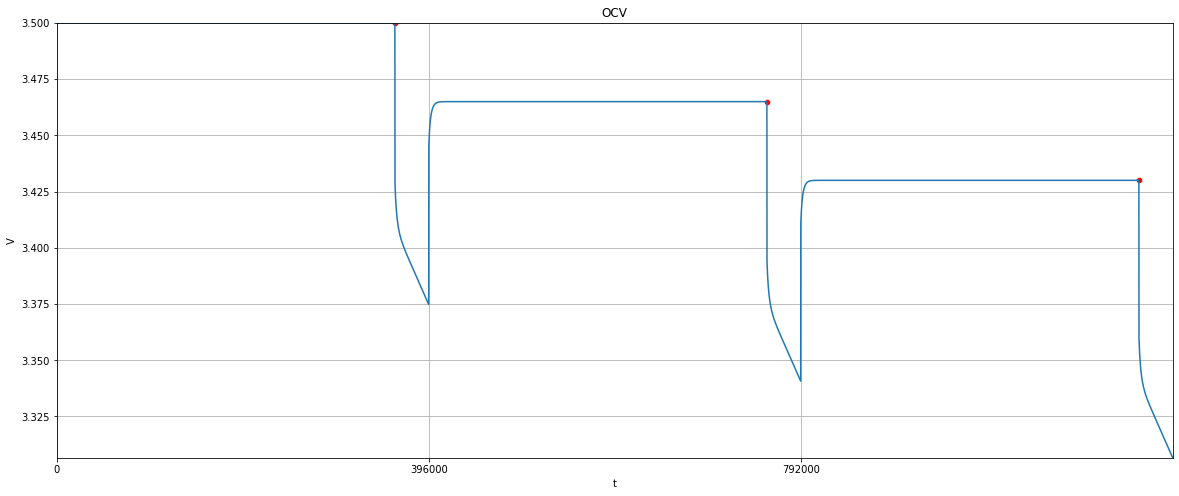

In [9]:
plt.figure(figsize=(20, 8))
sns.scatterplot(data=df_ovc.to_pandas(), x='t', y='V', color='red')
sns.lineplot(data=df.to_pandas(), x='t', y='V')
plt.grid()
plt.title('OCV')
plt.ylim([min(V), max(V)])
plt.xlim([0, len(V)])
plt.xticks(np.arange(0, len(V), pausa+descarga))
plt.show()
plt.close()

### R0

In [10]:
# Retira os pontos relevantes para determinar o R0
r0_hat = df.filter(
    ps.col('dI') < 0 # Somente pontos com a variação da corrente sendo negativa
).select([
    ps.col('t')-1, # t-1
    (ps.col('dV')/i0).alias('r0'), # r0
    ps.col('V') # r0
])

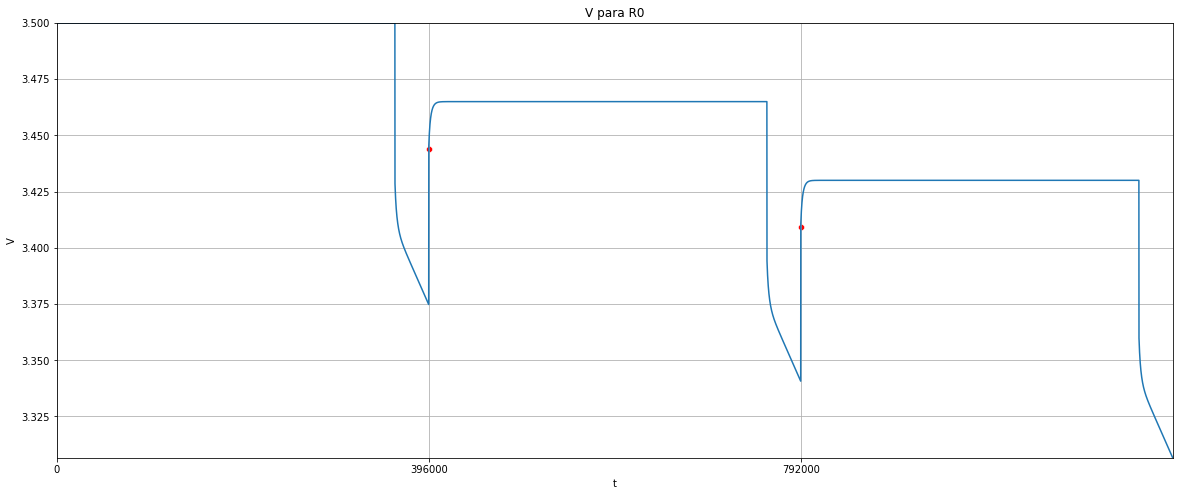

In [11]:
# Pontos que foram usados para identificação de R0
plt.figure(figsize=(20, 8))
sns.scatterplot(data=r0_hat.to_pandas(), x='t', y='V', color='red')
sns.lineplot(data=df.to_pandas(), x='t', y='V')
plt.grid()
plt.title('V para R0')
plt.ylim([min(V), max(V)])
plt.xlim([0, len(V)])
plt.xticks(np.arange(0, len(V), pausa+descarga))
plt.show()
plt.close()

### Delimita o intervalo da curva

In [12]:
# A curva começa na tensão utilizada para identificar o R0
r0_hat['tipo'] = np.zeros(len(r0_hat)) # 0 para inicio
df_c = r0_hat[['t','tipo']]
r0_hat = r0_hat.drop(['tipo'])

# E termina na tensão utilizada para identificar o OCV
df_ovc['tipo'] = np.ones(len(df_ovc)) # 1 para fim
df_c.extend(df_ovc[['t','tipo']])
df_ovc = df_ovc.drop(['tipo'])

df_c.sort('t',in_place=True)

# Dataframe intermediario com os pontos de R0 e OCV
df_c = df_c.select(
    [
        ps.col('t').shift(1).alias('t_inicio')+1,
        ps.col('t').alias('t_fim'),
        ps.col('tipo'),
    ]
).filter(ps.col('tipo')==1.0 # Filtra somente os pontos de fim
).filter(ps.col('t_inicio').is_not_null() # Retirar os valores nulos do inicio
).filter(ps.col('t_fim').is_not_null() # Retirar os valores nulos do fim
).select([ps.col('t_inicio'), ps.col('t_fim')]) # Colunas de interesse

### Determina o valor da constante de tempo - Tau

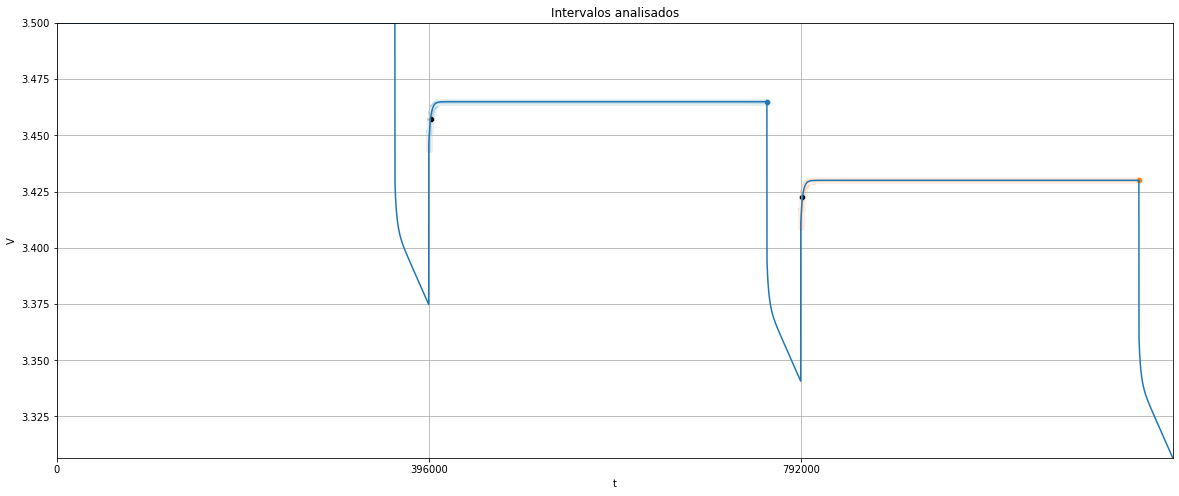

In [13]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=df.to_pandas(), x='t', y='V')

tau = dict() # R1*C1

for t_inicio, t_fim in df_c.rows():
    # Entra a diferença entre o V para R0 e o V para OCV
    v0 = df.filter(ps.col('t')==t_inicio)['V'].max()
    vinf = df.filter(ps.col('t')==t_fim)['V'].max()
    dv = vinf-v0

    # Percorre todos os valores intermediarios entre t_inicio e t_fim
    for i in range(t_inicio, t_fim):
        # Determina o V para aquele ponto
        vx = df.filter(ps.col('t')==i)['V'].max()
        
        # Caso a diferença seja 63.212% de dv (equivalente a diferença após uma constante de tempo Tau)
        if vx-v0 >= 0.632120*dv:
            # Determina-se o periodo entre esse ponto e o inicio como a constante de tempo Tau
            tau[t_inicio-1] = (i-t_inicio-0.5)*d_t #Existe um problema, que a precisão deste valor é somente de 1s
            break

    # Plota o a curva positiva analisada
    if tau:
        a = df.filter(ps.col('t')>=t_inicio).filter(ps.col('t')<=t_fim)
        sns.scatterplot(data=a.to_pandas(), x='t', y='V')

        a = df.filter(ps.col('t')==i)
        sns.scatterplot(data=a.to_pandas(), x='t', y='V', color='black', markers='*')

plt.ylim([min(V), max(V)])
plt.xlim([0, len(V)])
plt.xticks(np.arange(0, len(V), pausa+descarga))
plt.title('Intervalos analisados')
plt.grid()
plt.show()
plt.close()   

### Determina o valor de R1

In [14]:
r1_hat = dict()

for t_inicio, t_fim in df_c.rows():
    t = t_inicio-1 # Ajusta o tempo em relação a df_c
    # Encontra a diferença de tensão máxima entre o inicio e o fim do intervalo
    dv = (df[t:t_fim+1]['V'].max() - df[t:t_fim+1]['V'].min())
    # Encontra R1 para o intervalo através do valor de R0 e da diferença de tensão
    r1_hat[t] = dv/i0-r0_hat.filter(ps.col('t')==t)['r0'].max()

# Transforma R1 em um dataframe
r1_hat = ps.DataFrame({'t':list(r1_hat.keys()), 'r1':list(r1_hat.values())})

In [15]:
c1_hat = dict()

for t_inicio, t_fim in df_c.rows():
    t = t_inicio-1 # Ajusta o tempo em relação a df_c
    # Pega o R1 correspondente ao intervalo
    r1_ = r1_hat.filter(ps.col('t')==t)['r1'].max()
    # C1 = Tau/R1
    c1_hat[t] = tau[t]/(r1_)

# Transforma C1 em um dataframe
c1_hat = ps.DataFrame({'t':list(c1_hat.keys()), 'c1':list(c1_hat.values())})

### Parametros para o modelo 1RC

In [16]:
df_ovc

t,V
i64,f64
359999,3.5
755999,3.465
1151999,3.43


In [17]:
c1_hat

t,c1
i64,f64
395999,92016.480676
791999,91119.974099


In [18]:
r1_hat

t,r1
i64,f64
395999,0.000209
791999,0.000207


In [19]:
r0_hat

t,r0,V
i64,f64,f64
395999,0.000693,3.444085
791999,0.000686,3.409297


In [20]:
print('Erro em relação ao valor máximo dos parametros no modelo 2RC')
print(df_ovc['V'].max()-OCV(1))
print(r0_hat['r0'].max()-r0(1))
print(r1_hat['r1'].max()-r1(1))
print(c1_hat['c1'].max()-c1(1))
print()
print('Valor máximo dos parametros no modelo 1RC')
print(df_ovc['V'].max())
print(r0_hat['r0'].max())
print(r1_hat['r1'].max())
print(c1_hat['c1'].max())

Erro em relação ao valor máximo dos parametros no modelo 2RC
0.0
-7.009469128399959e-06
5.034731642255982e-05
-66483.51932416129

Valor máximo dos parametros no modelo 1RC
3.5
0.0006929905308716
0.00020914731642255983
92016.48067583871


## Outros testes

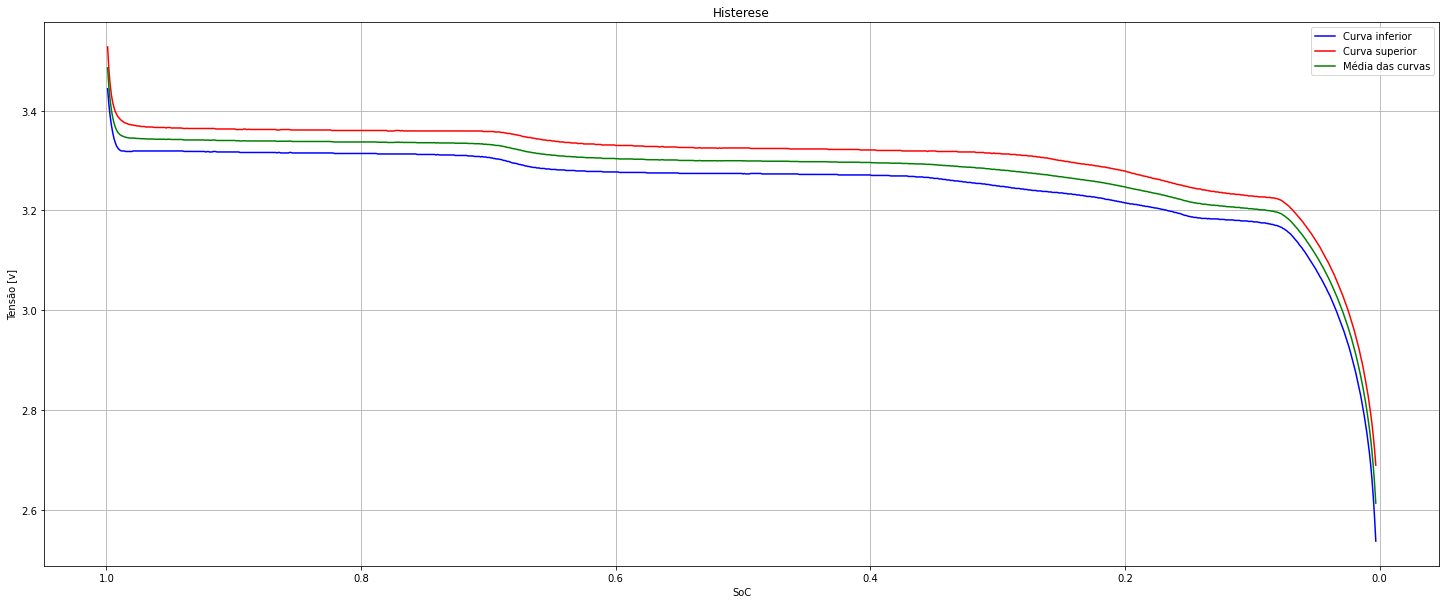

In [22]:
cs_sup = get_inter_soc_sup()
cs_inf = get_inter_soc_inf()
cs_mid = get_inter_soc_mid()
soc = np.arange(0.003, 1, 0.001)

plt.figure(figsize=(25, 10))
ax = sns.lineplot(x=soc, y=cs_inf(soc), color='blue', sort=False, label='Curva inferior')
ax = sns.lineplot(x=soc, y=cs_sup(soc), color='red', sort=False, label='Curva superior')
ax = sns.lineplot(x=soc, y=cs_mid(soc), color='green', sort=False, label='Média das curvas')
ax.invert_xaxis()
plt.xlabel('SoC')
plt.ylabel('Tensão [v]')
plt.grid()
plt.title('Histerese')
plt.show()
plt.close()

In [23]:
cs_mid(1)

3.5482684609691386